Checking input parameters are in the correct format...
Formatting Dates...
Checking if ticker supplied is available on the CoinBase Pro API...
Connected to the CoinBase Pro API...
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction...
Data for chunk 0 of 5 extracted
Data for chunk 1 of 5 extracted
Data for chunk 2 of 5 extracted
Data for chunk 3 of 5 extracted
Data for chunk 4 of 5 extracted
Data for chunk 5 of 5 extracted
TEST
Epoch: 0, loss: 0.94460
Epoch: 100, loss: 0.00122
Epoch: 200, loss: 0.00050
Epoch: 300, loss: 0.00033
Epoch: 400, loss: 0.00027
Epoch: 500, loss: 0.00022
Epoch: 600, loss: 0.00017
Epoch: 700, loss: 0.00014
Epoch: 800, loss: 0.00013
Epoch: 900, loss: 0.00012
Epoch: 1000, loss: 0.00012
Epoch: 1100, loss: 0.00011
Epoch: 1200, loss: 0.00011
Epoch: 1300, loss: 0.00010
Epoch: 1400, loss: 0.00010
Epoch: 1500, loss: 0.00010
Epoch: 1600, loss: 0.00009
Epoch: 1700, loss: 0.00009
Epoch: 1800, loss: 0.00009
Epoch: 1900, loss: 0.00008
done
Random: 0.5542

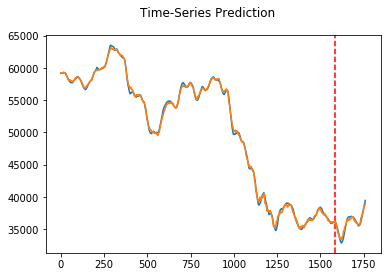

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import DataRetrieval as DR
import pickle
import talib as ta
import sklearn.metrics as skm


class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True).float()

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size) #reshape output from 1,train_len,hidden to train_len,hidden
        out = self.fc(h_out)
        return out

def prepare_data(data, labels, seq_length):
    x = []
    y = []
    for i in range(data.shape[0]-seq_length-1):
        _x = data[i: (i+seq_length)]
        _y = labels[i+seq_length]
        x.append(_x)
        y.append(_y)
    return x, y

def calculate_classification(test_x,test_y,lstm,labl_scaler):
    # Getting predictions for the test set.
    pred_y = lstm(test_x)

    # Transforming the labels back to original space
    orig_y = labl_scaler.inverse_transform(test_y.numpy()).tolist()
    pred_y = labl_scaler.inverse_transform(pred_y.detach().numpy()).tolist()

    # Transforming labels to be returns instead of price
    rtrn_y = [orig_y[i][0] - orig_y[i - 1][0] for i in range(1, len(orig_y))]
    rtrn_pred = [pred_y[i][0] - pred_y[i - 1][0] for i in range(1, len(pred_y))]

    # Getting Binary Classification
    bin_y = [1 if i > 0 else 0 for i in rtrn_y]
    bin_pred = [1 if i > 0 else 0 for i in rtrn_pred]
    return bin_y, bin_pred

# Don't 100% trust this yet. Need to clean up.
def print_acc(bin_y,bin_pred):
    # Getting accuracy
    acc = skm.accuracy_score(bin_y,bin_pred)

    # Accuracy if you randomly guessed
    rndm_acc = sum(bin_y) / len(bin_y)
    rndm_acc = max(1 - rndm_acc, rndm_acc)

    print("Random: " + str(rndm_acc))
    print("Accuracy: " + str(acc))


data_scaler = MinMaxScaler()
labl_scaler = MinMaxScaler()

## Update dataframe keys to lowercase for crypto
data_source = DR.get_crypto_data('BTC-USD',interval='1h',start_date='2021-04-01-00-00',end_date='2021-06-05-00-00')
# data_source = DR.get_stock_data('DIA',interval='1d',period='2y')


# Adding TAs
rsi = ta.RSI(data_source['Close'])
data_source['RSI'] = rsi

#Adding SMA
sma = ta.SMA(data_source['Close'])
data_source['SMA'] = sma

#Adding EMA
ema = ta.EMA(data_source['Close'])
data_source['EMA'] = ema

# Date High Low Open Close Volume AdjClose
scaled_data = data_scaler.fit_transform(data_source[['High','Low','Close','Volume','EMA']])[29:]
scaled_lbls = labl_scaler.fit_transform(data_source[['SMA']])[29:]
#normed = data_source[data_source.columns[1:]].apply(lambda x: x/x.max())



seq_length = 10
x, y = prepare_data(scaled_data, scaled_lbls, seq_length)
dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))
train_size = int(len(y) * 0.9)
train_x = torch.Tensor(x[0:train_size])
train_y = torch.Tensor(y[0:train_size])
test_x = torch.Tensor(x[train_size:])
test_y = torch.Tensor(y[train_size:])

input_size = 5
hidden_size = 6
num_layers = 1
num_classes = 1
epochs = 2000
learning_rate = 0.01

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

"""TRAIN"""
lstm.train()
for epoch in range(epochs):
    outputs = lstm(train_x)
    optimizer.zero_grad()
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

"""TEST"""
lstm.eval()
train_predict = lstm(dataX)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = labl_scaler.inverse_transform(data_predict)
dataY_plot = labl_scaler.inverse_transform(dataY_plot.reshape(dataY_plot.shape[0],1))

plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()


print('done')

# Getting binary classification
bin_y, bin_pred = calculate_classification(test_x,test_y,lstm,labl_scaler)

# Printing Classification
print_acc(bin_y,bin_pred)

# Printing Confusion Matrix
cfn_mtrx = skm.confusion_matrix(bin_y,bin_pred)
print(cfn_mtrx)


In [ ]:
# Getting predictions for the test set.

In [16]:
# Getting predictions for the test set.
pred_y = lstm(test_x)

# Transforming the labels back to original space
orig_y = labl_scaler.inverse_transform(test_y.numpy()).tolist()
pred_y = labl_scaler.inverse_transform(pred_y.detach().numpy()).tolist()

# Transforming labels to be returns instead of price
rtrn_y = [orig_y[i][0] - orig_y[i - 1][0] for i in range(1, len(orig_y))]
rtrn_pred = [pred_y[i][0] - pred_y[i - 1][0] for i in range(1, len(pred_y))]

# Getting Binary Classification
bin_y = [1 if i > 0 else 0 for i in rtrn_y]
bin_pred = [1 if i > 0 else 0 for i in rtrn_pred]




array([[60, 18],
       [19, 78]])

array([-1.30468750e+00, -3.16406250e+00, -5.85937500e-02, -1.33046875e+01,
       -1.62617188e+01, -1.64843750e+01, -1.96796875e+01, -1.76367188e+01,
       -1.56367188e+01, -2.58164062e+01, -2.48125000e+01, -2.15351562e+01,
       -2.29843750e+01, -2.93828125e+01, -2.96953125e+01, -2.97656250e+01,
       -2.84531250e+01, -2.75351562e+01, -2.53710938e+01, -2.54414062e+01,
       -3.01640625e+01, -3.48437500e+01, -3.65976562e+01, -3.44648438e+01,
       -3.35898438e+01, -3.07460938e+01, -2.71289062e+01, -1.92617188e+01,
       -2.03007812e+01, -1.86367188e+01, -1.85625000e+01, -2.05664062e+01,
       -2.47968750e+01, -1.25703125e+01, -9.96093750e+00, -9.48828125e+00,
       -3.35937500e-01,  4.39843750e+00,  3.07812500e+00,  1.07265625e+01,
        9.38671875e+00,  1.31054688e+01,  1.66640625e+01,  1.83085938e+01,
        1.70898438e+01,  1.41796875e+01,  2.82968750e+01,  2.95976562e+01,
        2.75468750e+01,  2.39140625e+01,  3.12695312e+01,  3.71562500e+01,
        3.95585938e+01,  